In [1]:
import os
import sys
import os
from PIL import Image,ImageChops,ImageEnhance
def ela_image(path, quality=98):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image

In [2]:
import numpy as np

In [3]:
Real_image_path='/kaggle/input/casia-dataset/casia/CASIA2/Au/Au_arc_30446.jpg'
Fake_image_path1='../input/casia-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Fake_image_path2='/kaggle/input/casia-dataset/casia/CASIA1/Sp/Sp_D_NRN_A_sec0047_cha0007_0559.jpg'

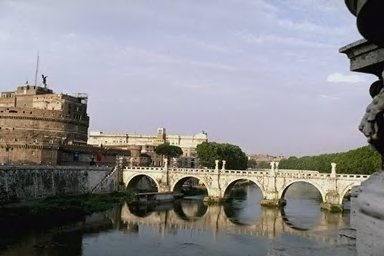

In [4]:
Image.open(Real_image_path)

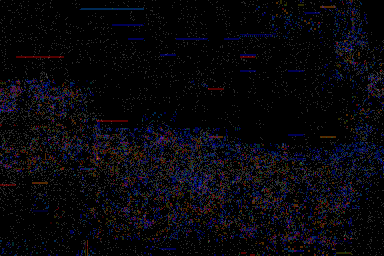

In [5]:
ela_image(Real_image_path)

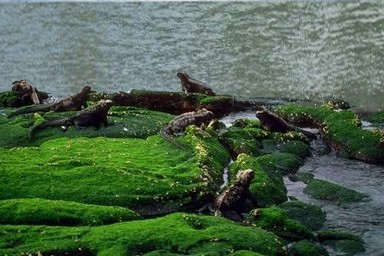

In [6]:
Image.open(Fake_image_path1)

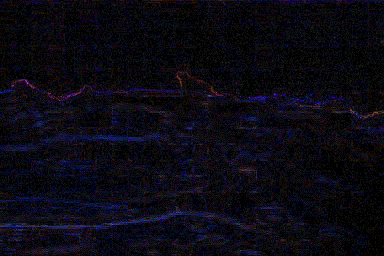

In [7]:
ela_image(Fake_image_path1)

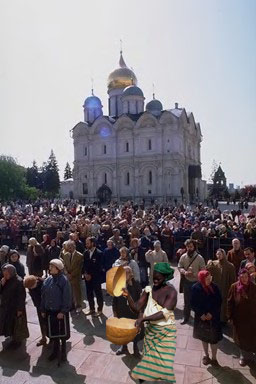

In [8]:
Image.open(Fake_image_path2)

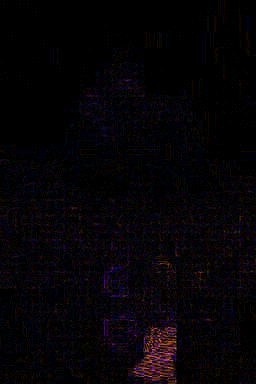

In [9]:
ela_image(Fake_image_path2)

In [10]:
image_size=(128,128)

In [11]:
import cv2  # Import OpenCV

In [12]:
def preprocessing(image_path):
    image_size = (128, 128)  # Define the target size for resizing
    image = cv2.imread(image_path)  # Read the image using OpenCV
    image = cv2.resize(image, image_size)  # Resize the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = image.flatten() / 255.0  # Flatten the image and normalize
    return np.array(image)


In [63]:
X=[]
Y=[]

In [64]:
import random
path = '/kaggle/input/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

2100 2100


In [65]:
len(X)

2100

In [66]:
path = '/kaggle/input/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
print(len(X), len(Y))

4164 4164


In [67]:
from keras.utils import to_categorical
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization,MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [21]:
model = Sequential()
model.add(layers.Input(shape=(128, 128, 3)))

# First set of convolutional layers
model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Second set of convolutional layers
model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Third set of convolutional layers
model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Fourth set of convolutional layers
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Fifth set of convolutional layers
model.add(layers.Conv2D(512, (3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Flatten and add dense layers
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(1200, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(700, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))

# Output layer for binary classification
model.add(Dense(units=2, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,173,894 (23.55 MB)

 Trainable params: 6,171,910 (23.54 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [23]:
#learning rate schedular
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.00001)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',             # Metric to monitor
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True       # Restore model weights from the epoch with the best value of the monitored metric
)


In [25]:
import tensorflow as tf


In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [27]:
print("X_train shape:", X_train.shape)  # Should be (num_samples, 128, 128, 3)
print("Y_train shape:", Y_train.shape)  # Should be (num_samples, 1)



X_train shape: (3331, 128, 128, 3)
Y_train shape: (3331, 2)


In [28]:
training_history = model.fit(X_train, Y_train,
                              validation_data=(X_val, Y_val),
                              epochs=50,
                              callbacks=[early_stopping, learning_rate_reduction])


Epoch 1/50


I0000 00:00:1731323917.709905     117 service.cc:145] XLA service 0x7cc7f4004af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731323917.709966     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4878 - loss: 21.8277

I0000 00:00:1731323929.055856     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5285 - loss: 15.2025

I0000 00:00:1731323940.113573     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 68 bytes spill stores, 68 bytes spill loads



105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - accuracy: 0.5286 - loss: 15.1566 - val_accuracy: 0.4898 - val_loss: 3.7587 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5606 - loss: 2.8158 - val_accuracy: 0.5102 - val_loss: 1.4555 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5829 - loss: 1.3129 - val_accuracy: 0.4742 - val_loss: 1.0455 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5672 - loss: 0.9921 - val_accuracy: 0.5546 - val_loss: 0.8802 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5719 - loss: 0.8566 - val_accuracy: 0.5510 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6041 - loss: 0.7930 - val_accuracy: 0.6086 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5464 - loss: 0.7805 - v

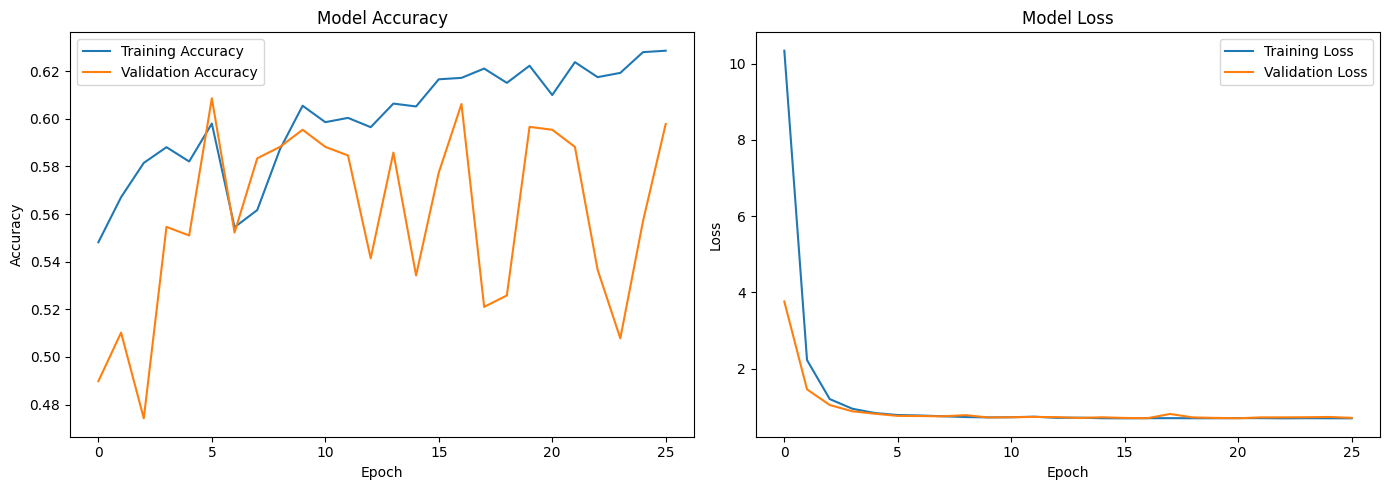

In [29]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = training_history.history

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [30]:
from tensorflow.keras import layers, regularizers
model2 = Sequential()
model2.add(layers.Input(shape=(128, 128, 3)))

# Adding convolutional and pooling layers
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01),activation='relu',input_shape=[128,128,3]))
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=2, strides=2))
# Adding 2nd convolutional and pooling layers
model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=2, strides=2))

# Adding convolutional and pooling layers
model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=2, strides=2))

model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=2, strides=2))

model2.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding='valid',kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model2.add(layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=2, strides=2))

#adding dense layers
model2.add(Dropout(0.25))#to avoid overfitting
model2.add(Flatten())

model2.add(Dense(units=1200,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.4))

# Output layer for binary classification
model2.add(Dense(units=2, activation='softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
#learning rate schedular
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.00001)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',             # Metric to monitor
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True       # Restore model weights from the epoch with the best value of the monitored metric
)


In [33]:
# Hyperparameters
epochs = 30
batch_size = 40
init_lr = 1e-4

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [35]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [36]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
# Fit the model
history1 = model2.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 120, validation_data = (X_val,Y_val),
                               steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,early_stopping])

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.5231 - loss: 12.5159 - val_accuracy: 0.4898 - val_loss: 11.5372 - learning_rate: 1.0000e-04
Epoch 2/120
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4000 - loss: 11.6818

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4000 - loss: 11.6818 - val_accuracy: 0.4898 - val_loss: 11.5245 - learning_rate: 1.0000e-04
Epoch 3/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.5785 - loss: 11.2870 - val_accuracy: 0.4898 - val_loss: 10.4785 - learning_rate: 1.0000e-04
Epoch 4/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5750 - loss: 10.4978 - val_accuracy: 0.4898 - val_loss: 10.4585 - learning_rate: 1.0000e-04
Epoch 5/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.5835 - loss: 10.1769 - val_accuracy: 0.4898 - val_loss: 9.4279 - learning_rate: 1.0000e-04
Epoch 6/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 9.4062 - val_accuracy: 0.4898 - val_loss: 9.4091 - learning_rate: 1.0000e-04
Epoch 7/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.6024 - loss: 9.1565 - val_accuracy: 0.4898 - val_loss: 8.5550 - learning_rate: 1.0000e-04
Epoch 8/120
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6

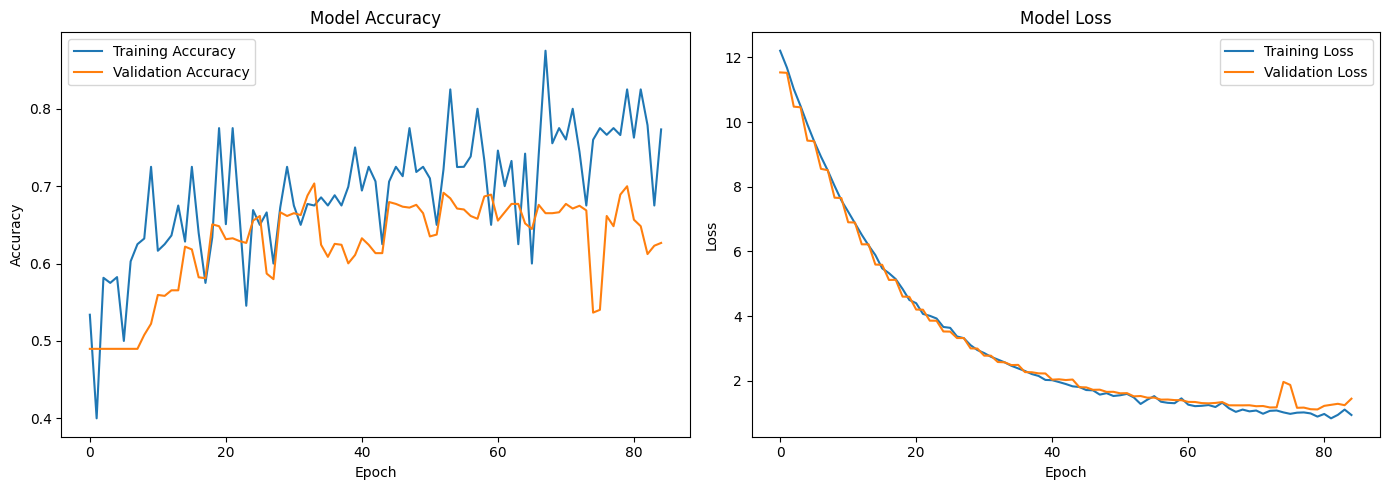

In [38]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history1.history

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [39]:
train_loss, train_acc = model2.evaluate(X_train,Y_train)
print('Training accuracy:', train_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7761 - loss: 0.9523
Training accuracy: 0.7739417552947998


In [40]:
val_loss, val_acc = model2.evaluate(X_val,Y_val)
print('Validation accuracy:', val_acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7012 - loss: 1.1046
Validation accuracy: 0.6998799443244934


In [68]:
X.shape

(4164, 128, 128, 3)

In [69]:
Y.shape

(4164, 2)

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

# Define the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='elu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='elu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model3.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model3.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an iterator for training
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = val_datagen.flow(X_val, Y_val, batch_size=32)

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history2 = model3.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32,
    callbacks=[reduce_lr, earlystopping, checkpoint]
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 15  # Choose a layer to

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4859 - loss: 0.9970
Epoch 1: val_loss improved from inf to 0.70907, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - accuracy: 0.4860 - loss: 0.9970 - val_accuracy: 0.5102 - val_loss: 0.7091 - learning_rate: 1.0000e-04
Epoch 2/50
  1/104 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3750 - loss: 1.2139
Epoch 2: val_loss did not improve from 0.70907
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3750 - loss: 1.2139 - val_accuracy: 0.5102 - val_loss: 0.7092 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4788 - loss: 1.0027
Epoch 3: val_loss improved from 0.70907 to 0.70905, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.4789 - loss: 1.0025 - val_accuracy: 0.5102 - val_loss: 0.7091 - learning_rate: 1.0000e-04
Epoch 4/50
  1/104 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5312 - loss: 0.9

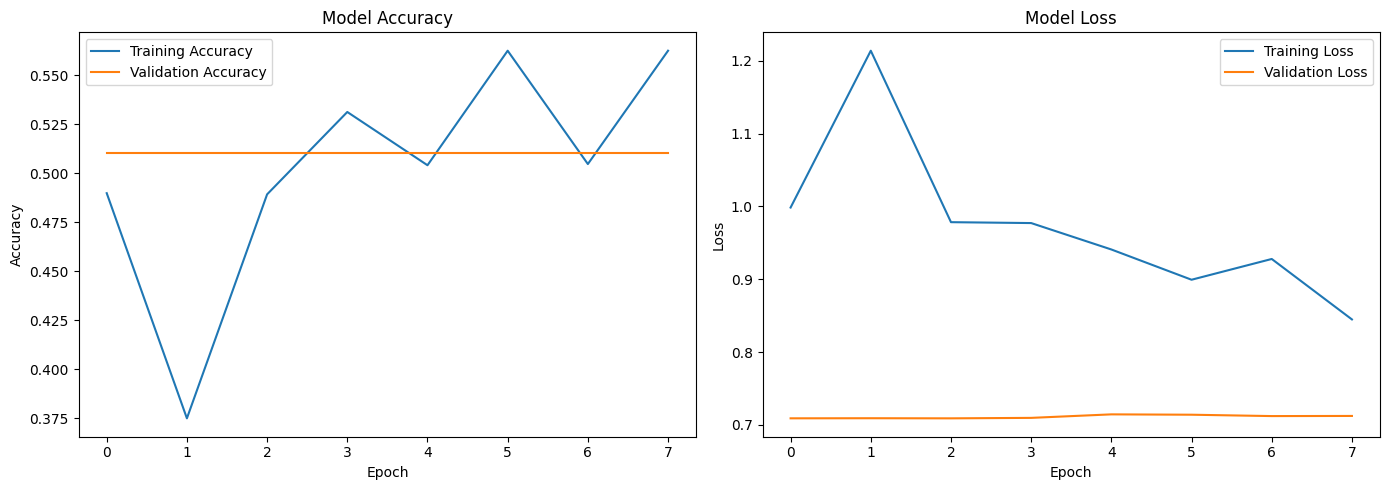

In [72]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history2.history

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [73]:
train_loss, train_acc = model3.evaluate(X_train,Y_train)
print('Training accuracy:', train_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5158 - loss: 0.7008
Training accuracy: 0.5100570321083069


In [74]:
val_loss, val_acc = model3.evaluate(X_val,Y_val)
print('Validation accuracy:', val_acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4844 - loss: 0.7102
Validation accuracy: 0.4981992840766907


In [77]:
print(X.shape)
print(Y.shape)

(4164, 128, 128, 3)
(4164, 2)


In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

# Define the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model4.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model4.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an iterator for training
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)

# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = val_datagen.flow(X_val, Y_val, batch_size=32)



# Train the model
history3 = model.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    steps_per_epoch=X_train.shape[0] // 32
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 14  # Choose a layer to fine-tune


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
 54/104 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - accuracy: 0.5804 - loss: 0.7037

I0000 00:00:1731325655.483003     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 68 bytes spill stores, 68 bytes spill loads



104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 221ms/step - accuracy: 0.5785 - loss: 0.7021 - val_accuracy: 0.5102 - val_loss: 0.7860
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6947 - val_accuracy: 0.5102 - val_loss: 0.7868
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.5799 - loss: 0.6933 - val_accuracy: 0.5102 - val_loss: 0.7653
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.7292 - val_accuracy: 0.5102 - val_loss: 0.7631
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5842 - loss: 0.6886 - val_accuracy: 0.5102 - val_loss: 0.7721
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 0.7344 - val_accuracy: 0.5102 - val_loss: 0.7684
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5901 - loss: 0.6838 - val_accuracy: 0.5282 - val_loss: 0.7082
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 0.6955 - val_accuracy: 0

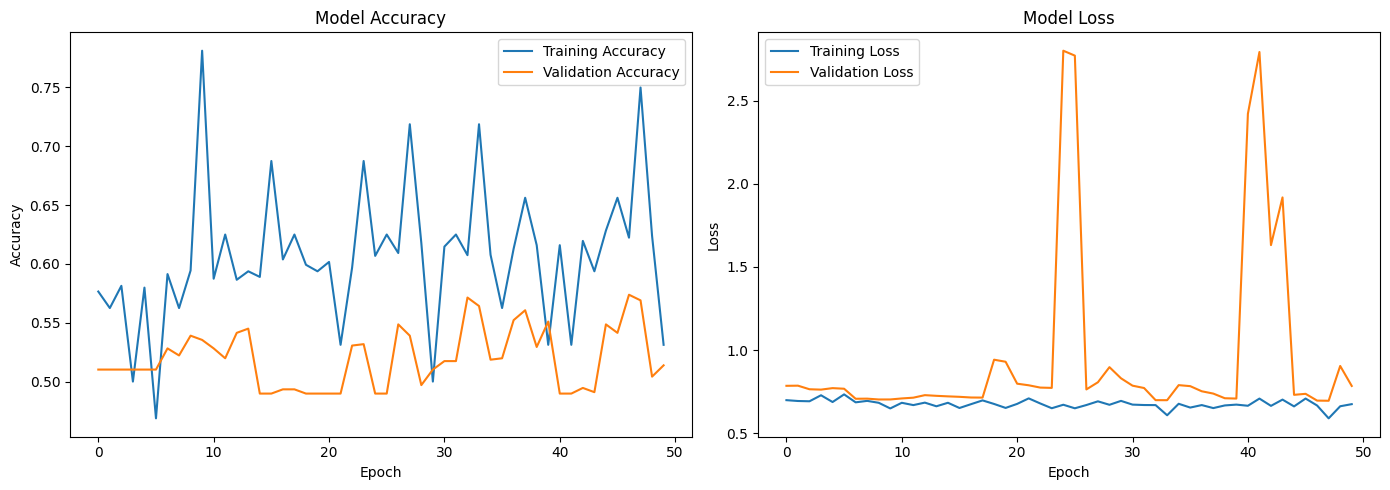

In [78]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history3.history

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [79]:
train_loss, train_acc = model4.evaluate(X_train,Y_train)
print('Training accuracy:', train_acc)

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4888 - loss: 0.8383
Training accuracy: 0.4971480071544647


In [80]:
val_loss, val_acc = model4.evaluate(X_val,Y_val)
print('Validation accuracy:', val_acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5001 - loss: 0.8249
Validation accuracy: 0.4897959232330322
